In [1]:
import requests
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pprint import pprint
from statistics import mean
from requests.auth import HTTPBasicAuth
from client import client_id, client_secret

In [2]:
## Authorization token to access spotify api (Required for all endpoints)
token_url = "https://accounts.spotify.com/api/token"
headers = {'content-type': 'application/x-www-form-urlencoded'}

token_params = {"grant_type" : "client_credentials"}

token_json = requests.post(token_url, params = token_params, headers = headers, auth = (client_id, client_secret)).json()
token = token_json['access_token']

In [3]:
token_headers = {'authorization': f"Bearer {token}"}

US_top50_df = pd.read_csv("Top Country CSV/US_top_50.csv")

artist_count = 0
genres = []
genre_count = []

search_artist_url = "https://api.spotify.com/v1/artists/"

for artist_id in US_top50_df["Artist ID"]:
    artist_url = search_artist_url + artist_id
    
    artist_json = requests.get(artist_url, headers = token_headers).json()
    
    try:
        genres_list = artist_json["genres"]
        
        for genre in genres_list:
            if genre not in genres:
                genres.append(genre)
                genre_count.append(1)

            else:
                genre_count[genres.index(genre)] += 1
                
        artist_count += 1
                
    except (KeyError, IndexError):
        print(f"Artist ID not found | {artist_id}")
        
genre_zip = zip(genres, genre_count)
sorted_genre_zip = sorted(genre_zip, key = lambda count : count[1], reverse = True)

genre = list(zip(*sorted_genre_zip))[0]
genre_count = list(zip(*sorted_genre_zip))[1]

In [4]:
# Create DataFrame with genre, genre counts, and percentage of artist that lie within the genre
genre_popularity_df = pd.DataFrame({"Genres" : genre, "Genre Counts" : genre_count})
genre_popularity_df["Genre Popularity Percentage"] = (genre_popularity_df["Genre Counts"]/artist_count) * 100
genre_popularity_df.head()

,Genres,Genre Counts,Genre Popularity Percentage
0,pop,33,66.0
1,rap,25,50.0
2,trap music,19,38.0
3,dance pop,15,30.0
4,pop rap,12,24.0


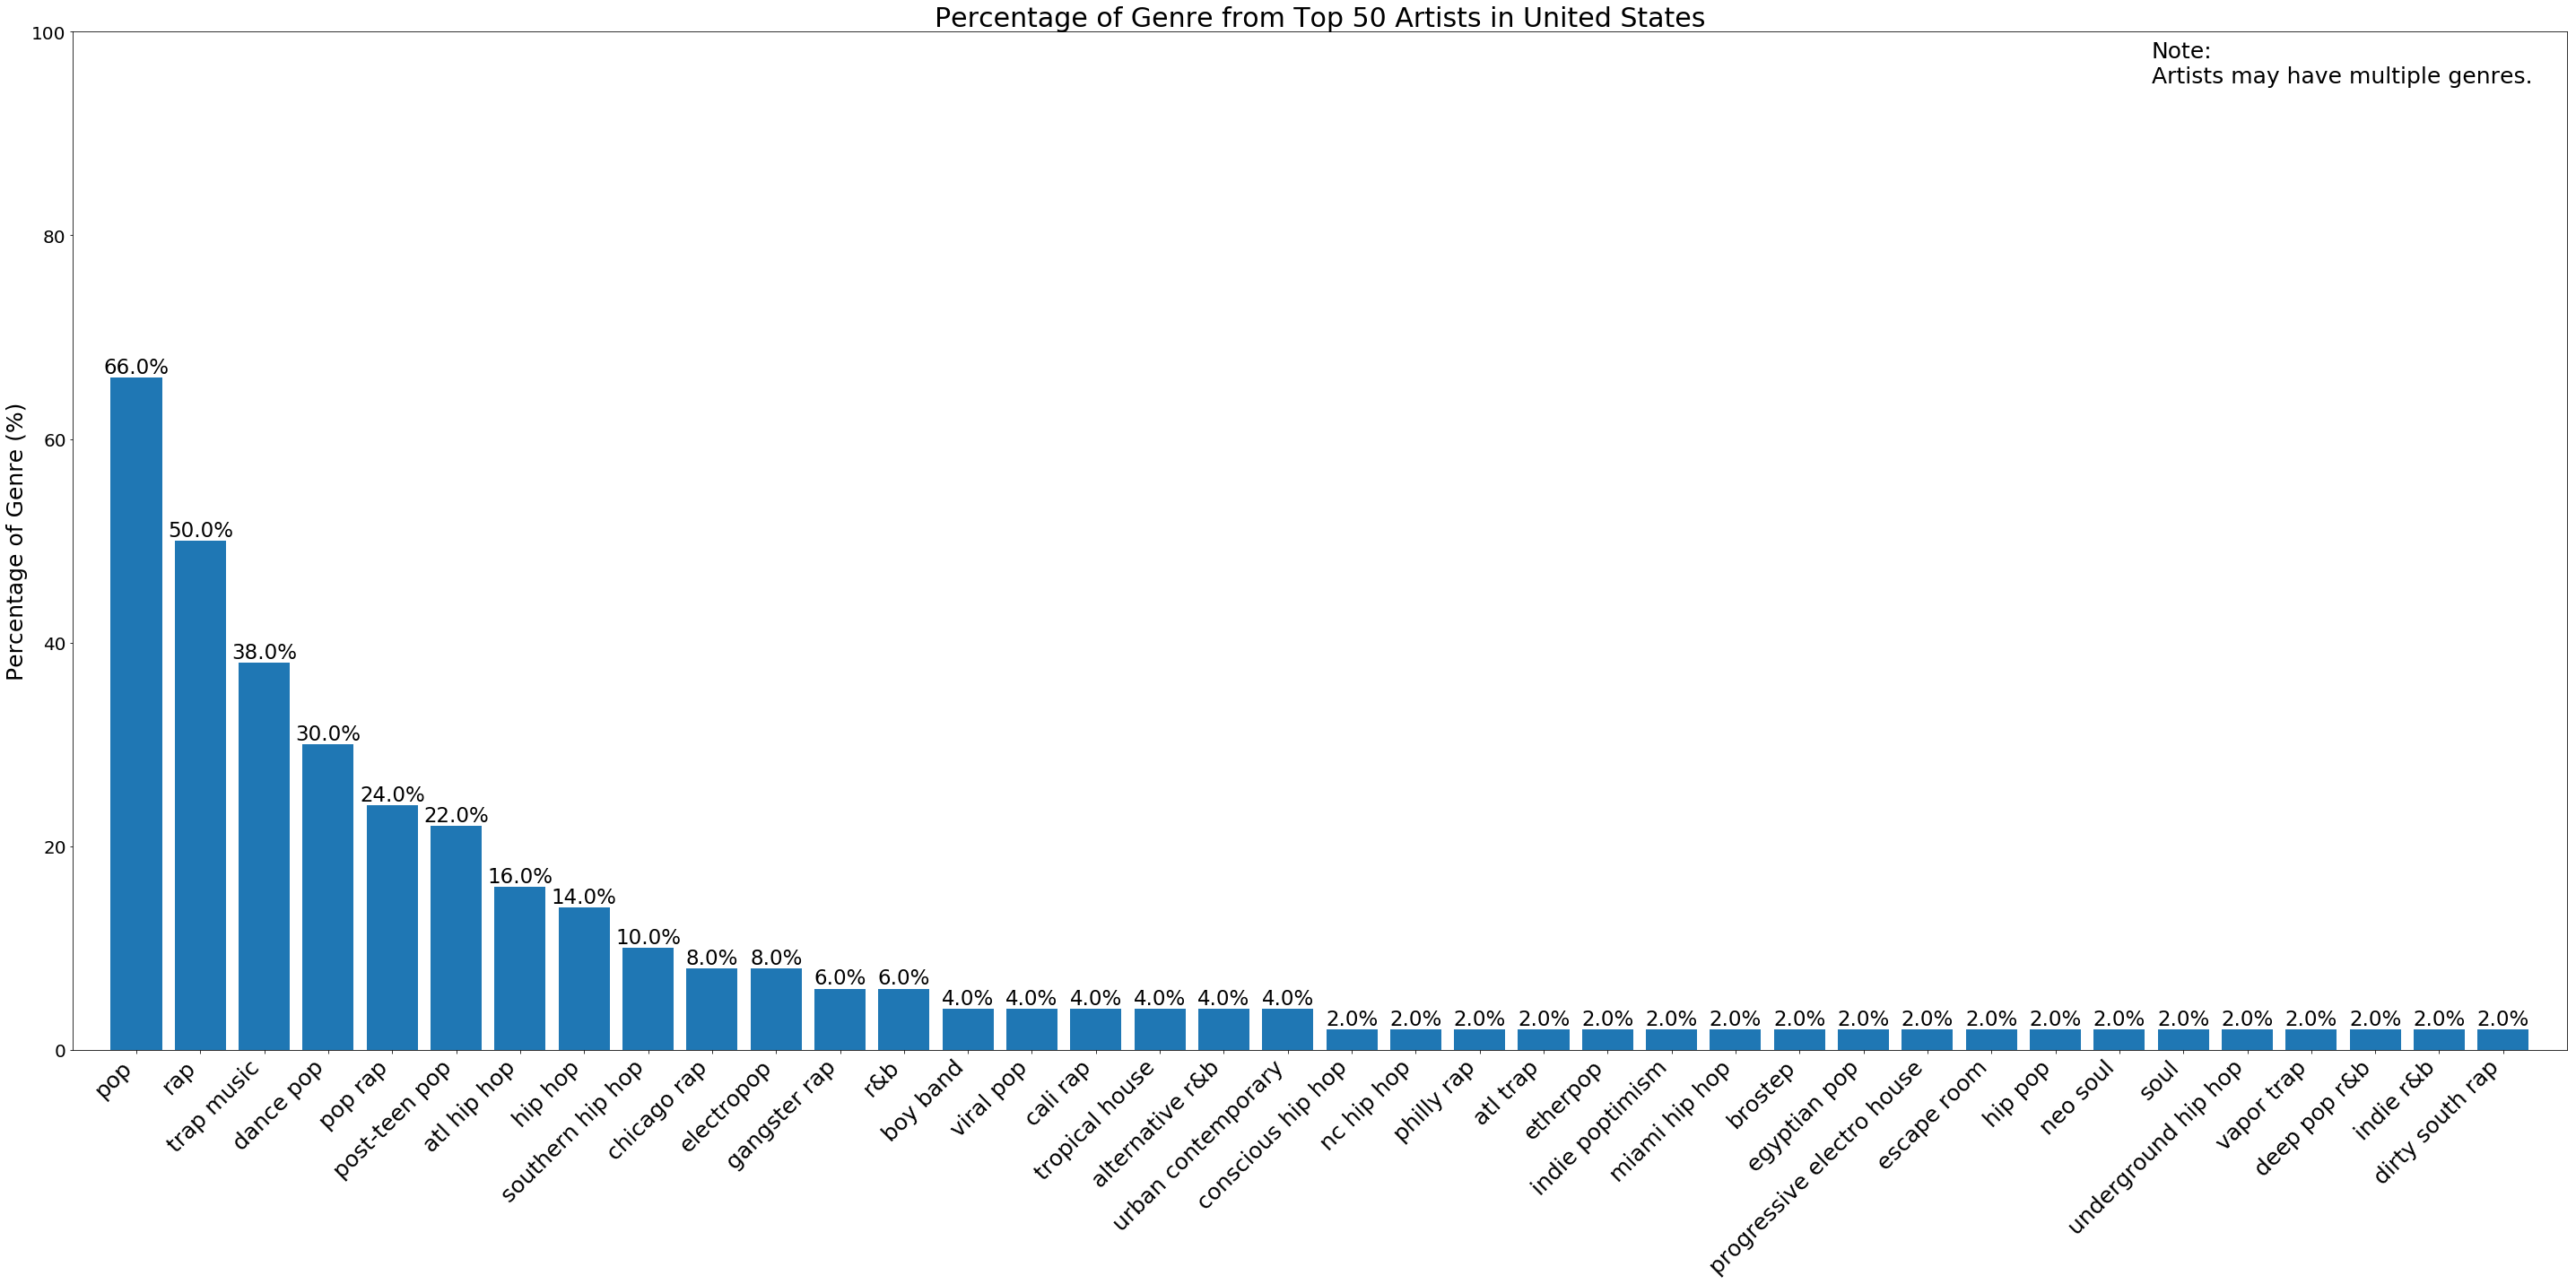

In [5]:
fig, ax = plt.subplots(figsize = (40,20))

# Number of genres
x_axis = np.arange(len(genre))

# Percentage of genres
y_axis = genre_popularity_df["Genre Popularity Percentage"]

# Create bar graph showing percentage of genres in US
ax.bar(x_axis, y_axis)

# Label x axis with genres
plt.xticks(x_axis, genre_popularity_df["Genres"], Fontsize = 25, rotation = 45, ha = "right")
plt.yticks(Fontsize = 20)

plt.xlim(min(x_axis) - 1, max(x_axis) + 1)
plt.ylim(0, 100)

plt.ylabel("Percentage of Genre (%)", Fontsize = 25)
plt.title("Percentage of Genre from Top 50 Artists in United States", Fontsize = 30)
plt.text(max(x_axis) - 5.5, 95, "Note:\nArtists may have multiple genres.", Fontsize = 25)

# Dimension of each box
rects = ax.patches

# Loops through each box to rab dimensions
for rect in rects:
    
    # Width of Box
    box_width = rect.get_width()
    
    # Height of Box
    height = rect.get_height()
    
    # Center of Box
    center = rect.get_x() + box_width / 2
    
    # Text is above boxes if height greater than 0
    if height > 0:
        ax.text(center, height, f'{round(height,2)}%', Fontsize = 23, ha = 'center', va = 'bottom')
        
    # Text is below boxes if height is less than 0
    else:
         ax.text(center, height, f'{round(height,2)}%', Fontsize = 23, ha = 'center', va = 'top')

plt.tight_layout()

plt.savefig("Images/Percentage_of_ALL_Genre_from_Top50_Artists_in_US.png")
            
plt.show()

In [6]:
search_artist_url = "https://api.spotify.com/v1/artists/"

artist_count = 0

pop_count = 0
pop_danceability = []

trap_count = 0
trap_danceability = []

rap_count = 0
rap_danceability = []

for i in range(len(US_top50_df["Artist ID"])):
    artist_url = search_artist_url + US_top50_df["Artist ID"][i]
    
    artist_json = requests.get(artist_url, headers = token_headers).json()
    
    try:
        genre_list = artist_json["genres"]
        
        if "pop" in genre_list:
            pop_count += 1
            pop_danceability.append(US_top50_df["Danceability"][i])
            
        if "trap music" in genre_list:
            trap_count += 1
            trap_danceability.append(US_top50_df["Danceability"][i])
            
        if "rap" in genre_list:
            rap_count += 1
            rap_danceability.append(US_top50_df["Danceability"][i])
                
        artist_count += 1
                
    except (KeyError, IndexError):
        print(f"Artist ID not found | {artist_id}")

In [7]:
stats.ttest_ind(pop_danceability, rap_danceability, equal_var=False)

Ttest_indResult(statistic=-1.1650744904304908, pvalue=0.24909237994142375)

In [8]:
stats.ttest_ind(pop_danceability, trap_danceability, equal_var=False)

Ttest_indResult(statistic=-0.88018215016514, pvalue=0.3839378808625732)

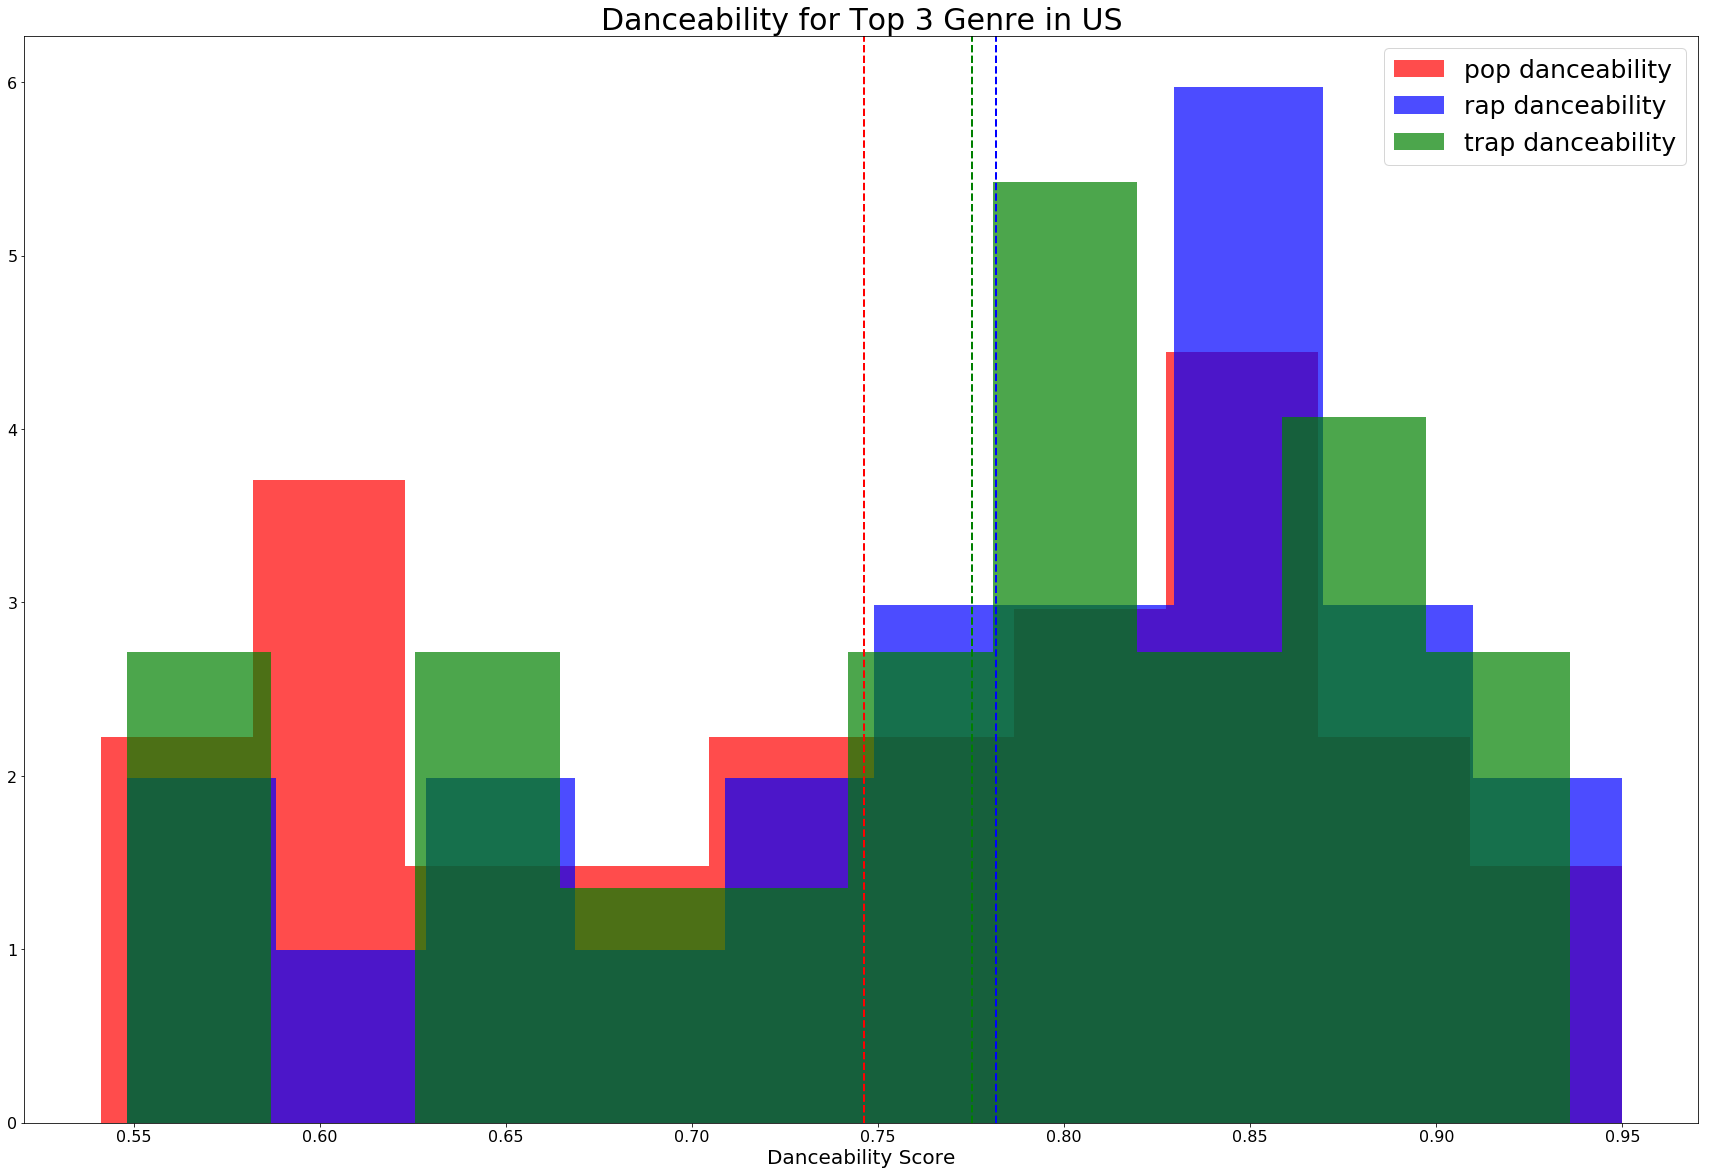

In [9]:
fig, ax = plt.subplots(figsize = (30,20))

ax.hist(pop_danceability, density = True, alpha = 0.7, color = 'r', label = "pop danceability")
ax.hist(rap_danceability, density = True, alpha = 0.7, color = 'b', label = "rap danceability")
ax.hist(trap_danceability, density = True, alpha = 0.7, color = 'g', label = "trap danceability")

ax.axvline(mean(pop_danceability), color='r', linestyle='dashed', linewidth = 2)
ax.axvline(mean(rap_danceability), color='b', linestyle='dashed', linewidth = 2)
ax.axvline(mean(trap_danceability), color = 'g', linestyle='dashed', linewidth = 2)

plt.xlabel("Danceability Score", Fontsize = 20)
plt.xticks(Fontsize = 16)
plt.yticks(Fontsize = 16)
plt.title("Danceability for Top 3 Genre in US", Fontsize = 30)

plt.legend(loc = "best", prop={'size': 25})

plt.savefig("Images/Danceability_Histogram_for_Top_3_Genre_in_US.png")

plt.show()

In [10]:
# Create DataFrame with only top 3 genres and their danceability scores
pop_danceability_df = pd.DataFrame({"Danceability" : pop_danceability})
pop_danceability_df.insert(0, "Genre", "pop")

rap_danceability_df = pd.DataFrame({"Danceability" : rap_danceability})
rap_danceability_df.insert(0, "Genre", "rap")

trap_danceability_df = pd.DataFrame({"Danceability" : trap_danceability})
trap_danceability_df.insert(0, "Genre", "trap")

# Combine all three DataFrames by appending to first
genre_danceability_df = pop_danceability_df.append([rap_danceability_df, trap_danceability_df])

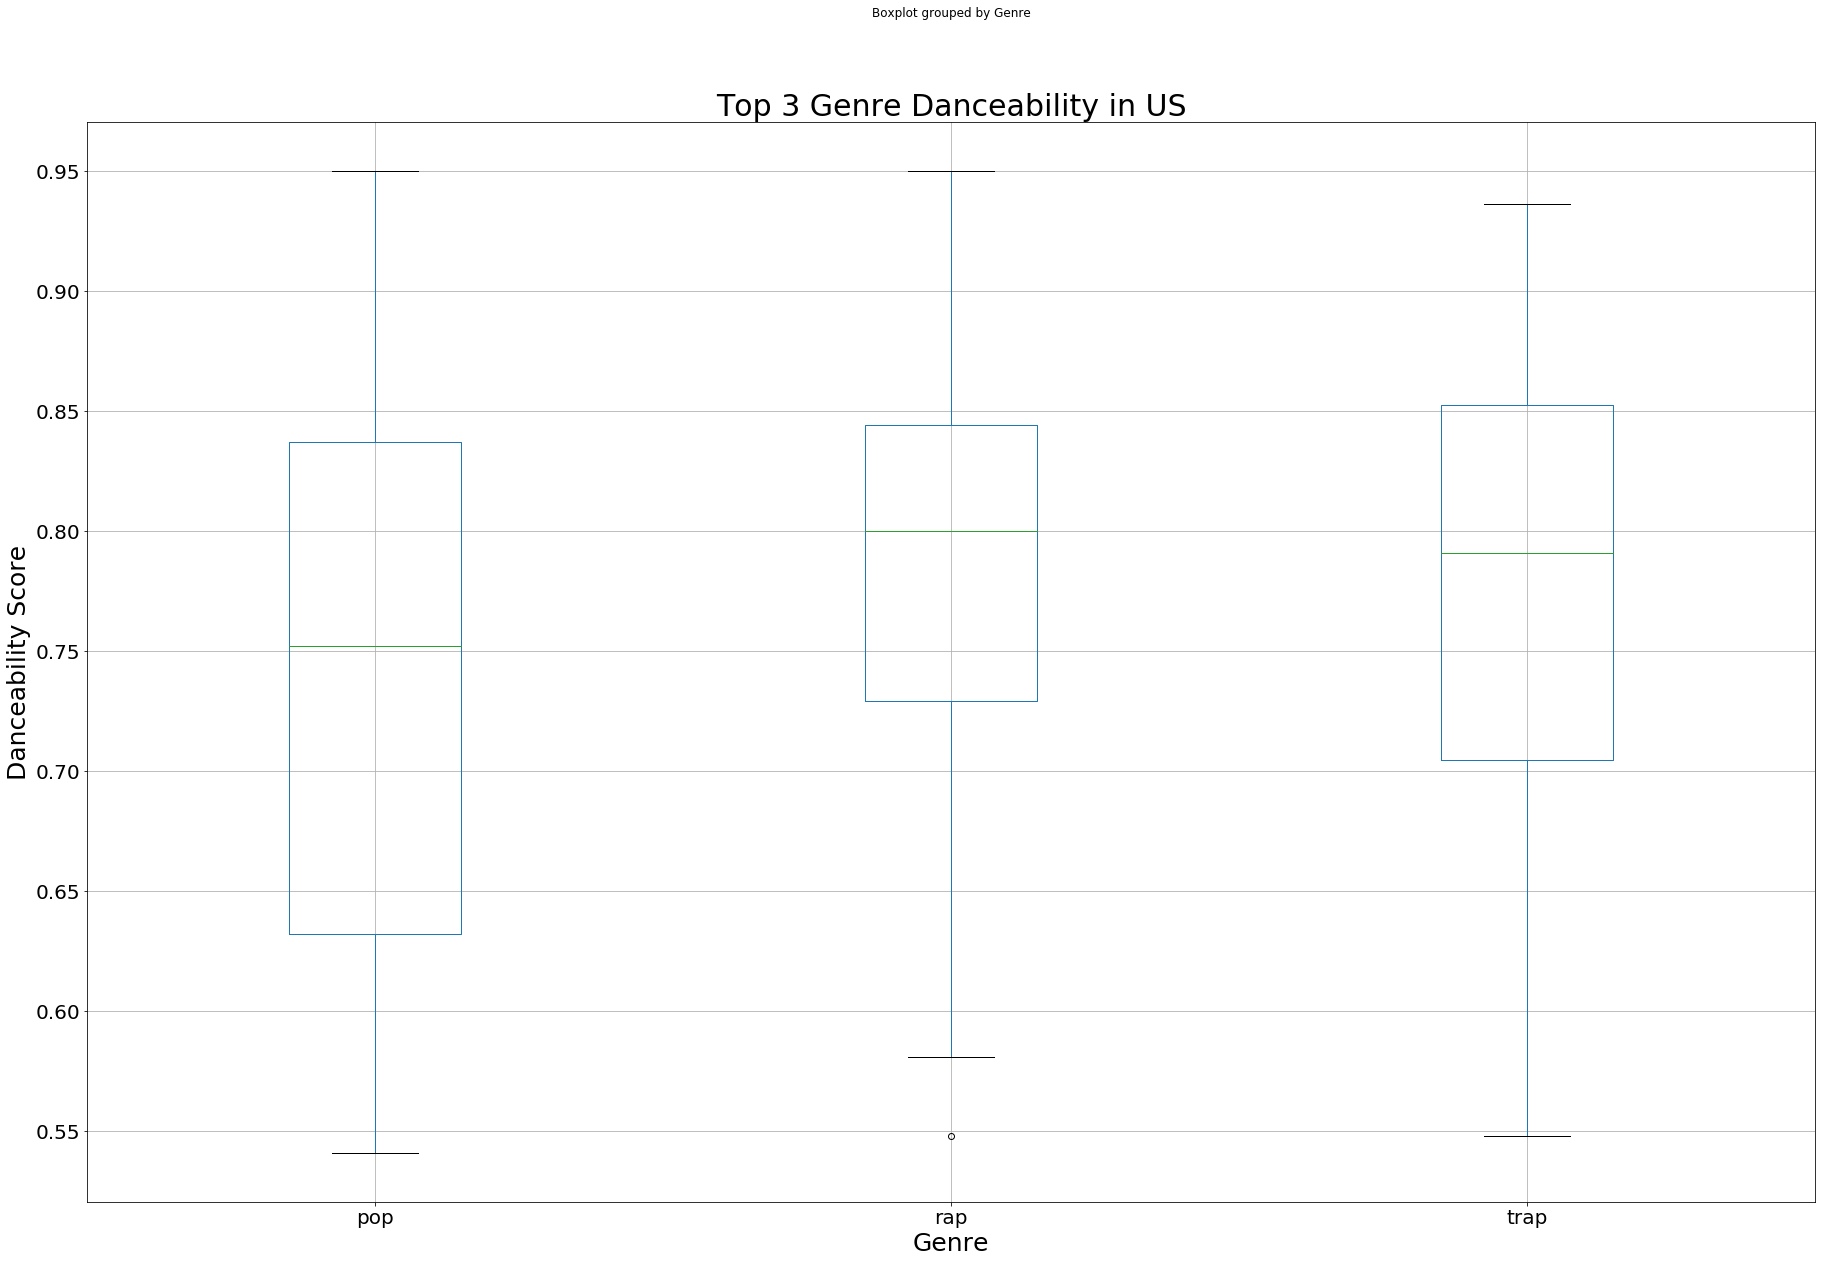

In [11]:
# Boxplot for top 3 genre danceability in US
genre_danceability_df.boxplot("Danceability", by = "Genre", figsize = (30,20))
plt.title("Top 3 Genre Danceability in US", Fontsize = 30)
plt.xticks(Fontsize = 20)
plt.yticks(Fontsize = 20)
plt.xlabel("Genre", Fontsize = 25)
plt.ylabel("Danceability Score", Fontsize = 25)

plt.savefig("Images/Top_3_Genre_Danceability_in_US_Boxplot.png")

plt.show()

In [12]:
stats.f_oneway(pop_danceability, rap_danceability, trap_danceability)

F_onewayResult(statistic=0.7784554753217885, pvalue=0.4628374061031737)